In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.metrics import accuracy_score, classification_report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


### EDA

In [11]:
data = pd.read_csv('../data/Wholesale customers data.csv')
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [12]:
data.isna().sum()

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

In [13]:
data.duplicated().sum()

0

### Outlier handling

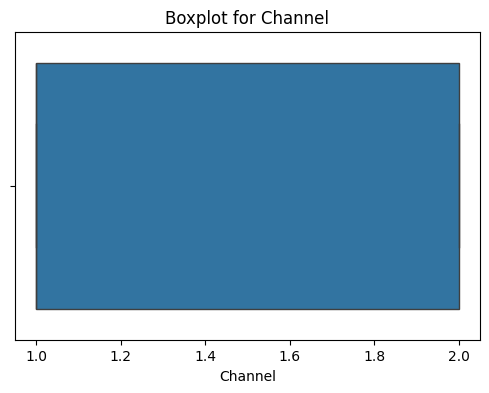

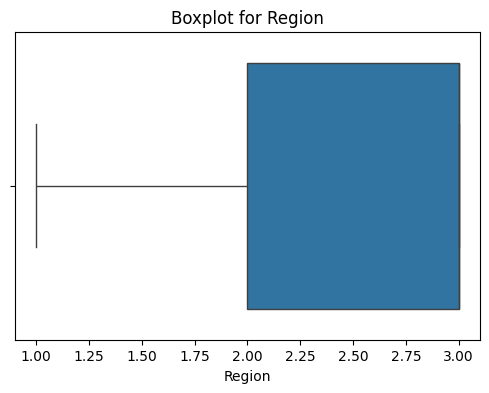

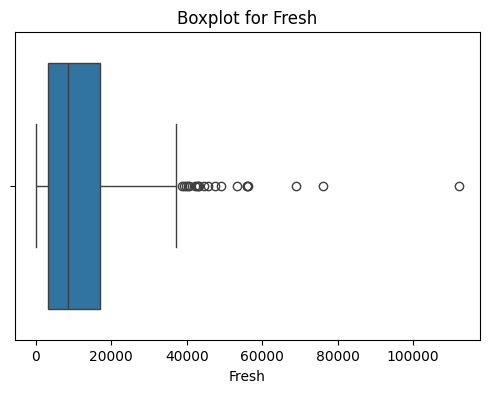

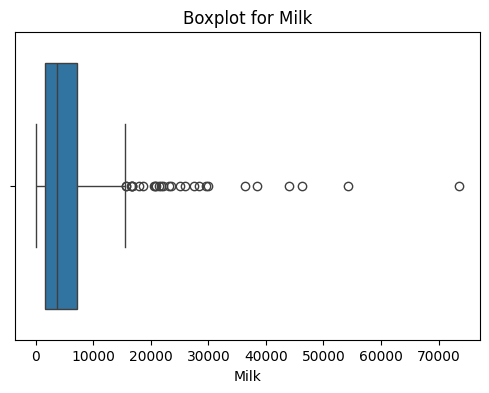

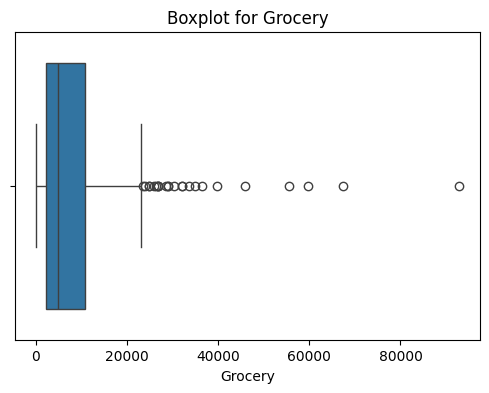

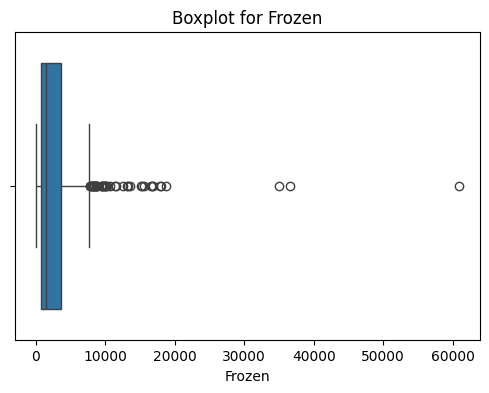

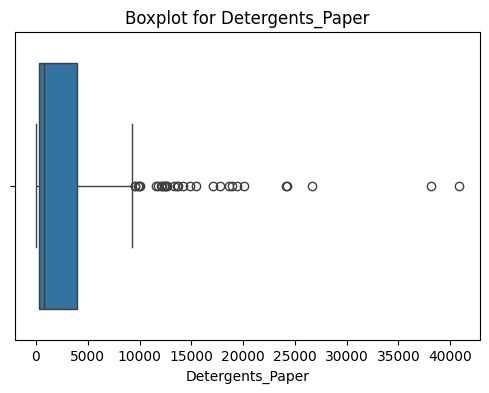

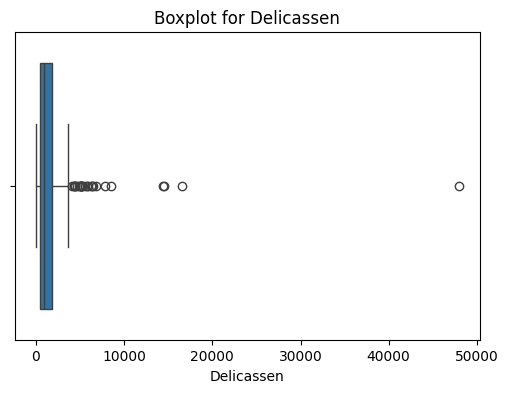

In [14]:
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [15]:
def handle_outliers_clip(data):
    for col in data.select_dtypes(include=[np.number]).columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        data[col] = data[col].clip(lower=lower_bound, upper=upper_bound)    
    return data

data_no_outliers_clip = handle_outliers_clip(data)
print(data_no_outliers_clip.head())

   Channel  Region    Fresh    Milk  Grocery  Frozen  Detergents_Paper  \
0        2       3  12669.0  9656.0   7561.0   214.0            2674.0   
1        2       3   7057.0  9810.0   9568.0  1762.0            3293.0   
2        2       3   6353.0  8808.0   7684.0  2405.0            3516.0   
3        1       3  13265.0  1196.0   4221.0  6404.0             507.0   
4        2       3  22615.0  5410.0   7198.0  3915.0            1777.0   

   Delicassen  
0     1338.00  
1     1776.00  
2     3938.25  
3     1788.00  
4     3938.25  


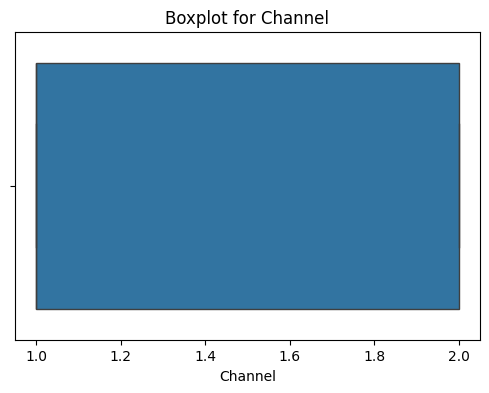

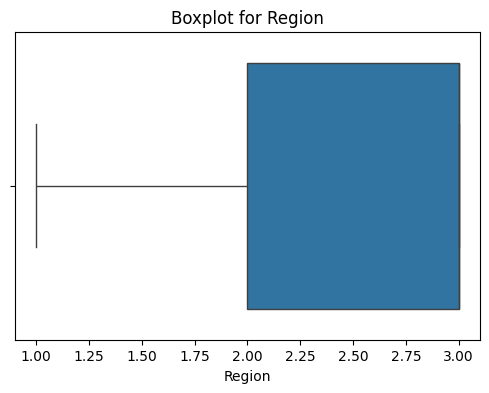

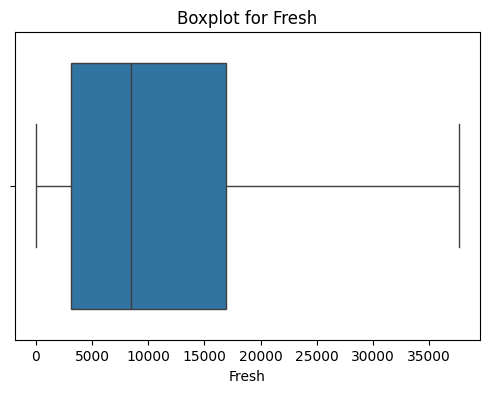

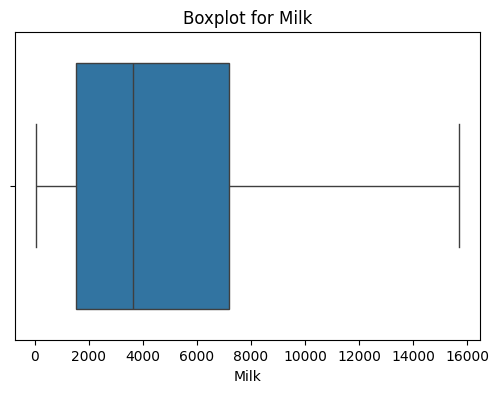

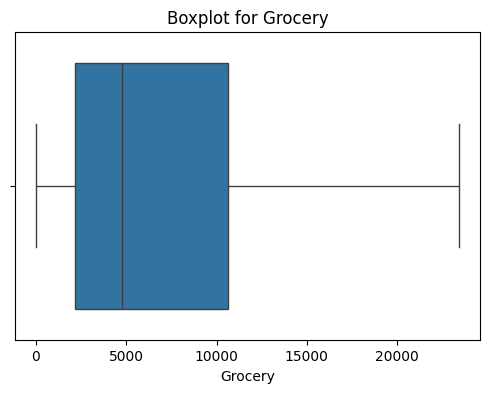

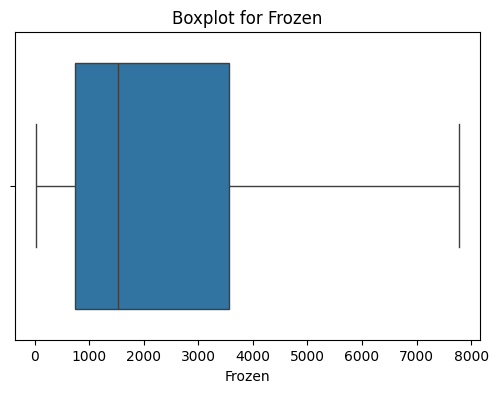

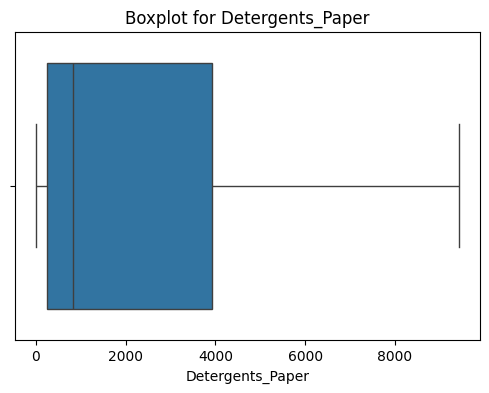

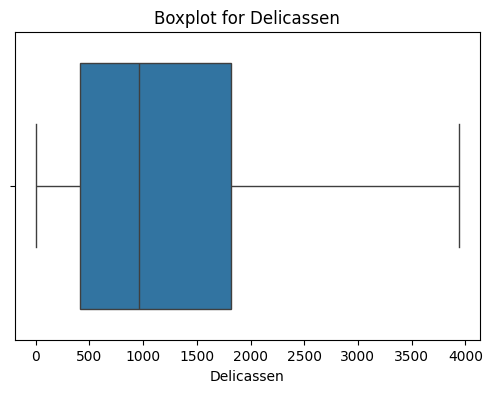

In [16]:
# checking if outliers still exist
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

In [17]:
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.00
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.00
2,2,3,6353.0,8808.0,7684.0,2405.0,3516.0,3938.25
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.00
4,2,3,22615.0,5410.0,7198.0,3915.0,1777.0,3938.25


In [18]:
X = data.drop(columns=['Channel', 'Region'])
X.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669.0,9656.0,7561.0,214.0,2674.0,1338.00
1,7057.0,9810.0,9568.0,1762.0,3293.0,1776.00
2,6353.0,8808.0,7684.0,2405.0,3516.0,3938.25
3,13265.0,1196.0,4221.0,6404.0,507.0,1788.00
4,22615.0,5410.0,7198.0,3915.0,1777.0,3938.25


### KMeans

In [19]:
### Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) #inertia is the sum of diff between centroid and corrsponding datapoint
    print('k:',i," wcss:",kmeans.inertia_)

k: 1  wcss: 80183945004.64621
k: 2  wcss: 46779052303.66911
k: 3  wcss: 29087026926.283386
k: 4  wcss: 22423106661.276447
k: 5  wcss: 19174243283.83683
k: 6  wcss: 16359548775.515778
k: 7  wcss: 14497809199.983181
k: 8  wcss: 13362525087.807405
k: 9  wcss: 12531081722.260185
k: 10  wcss: 11698322230.661781


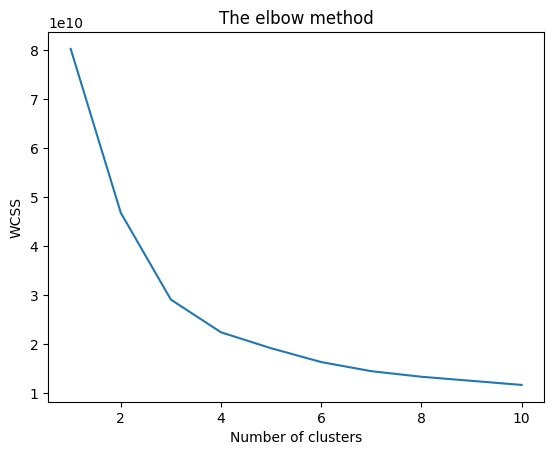

In [20]:
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 100, n_init = 10, random_state = 0)
Y = kmeans.fit_predict(X)
Y

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0,

In [22]:
data['Cluster'] = Y
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Cluster
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.00,1
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.00,1
2,2,3,6353.0,8808.0,7684.0,2405.0,3516.0,3938.25,1
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.00,1
4,2,3,22615.0,5410.0,7198.0,3915.0,1777.0,3938.25,0


### Plotting

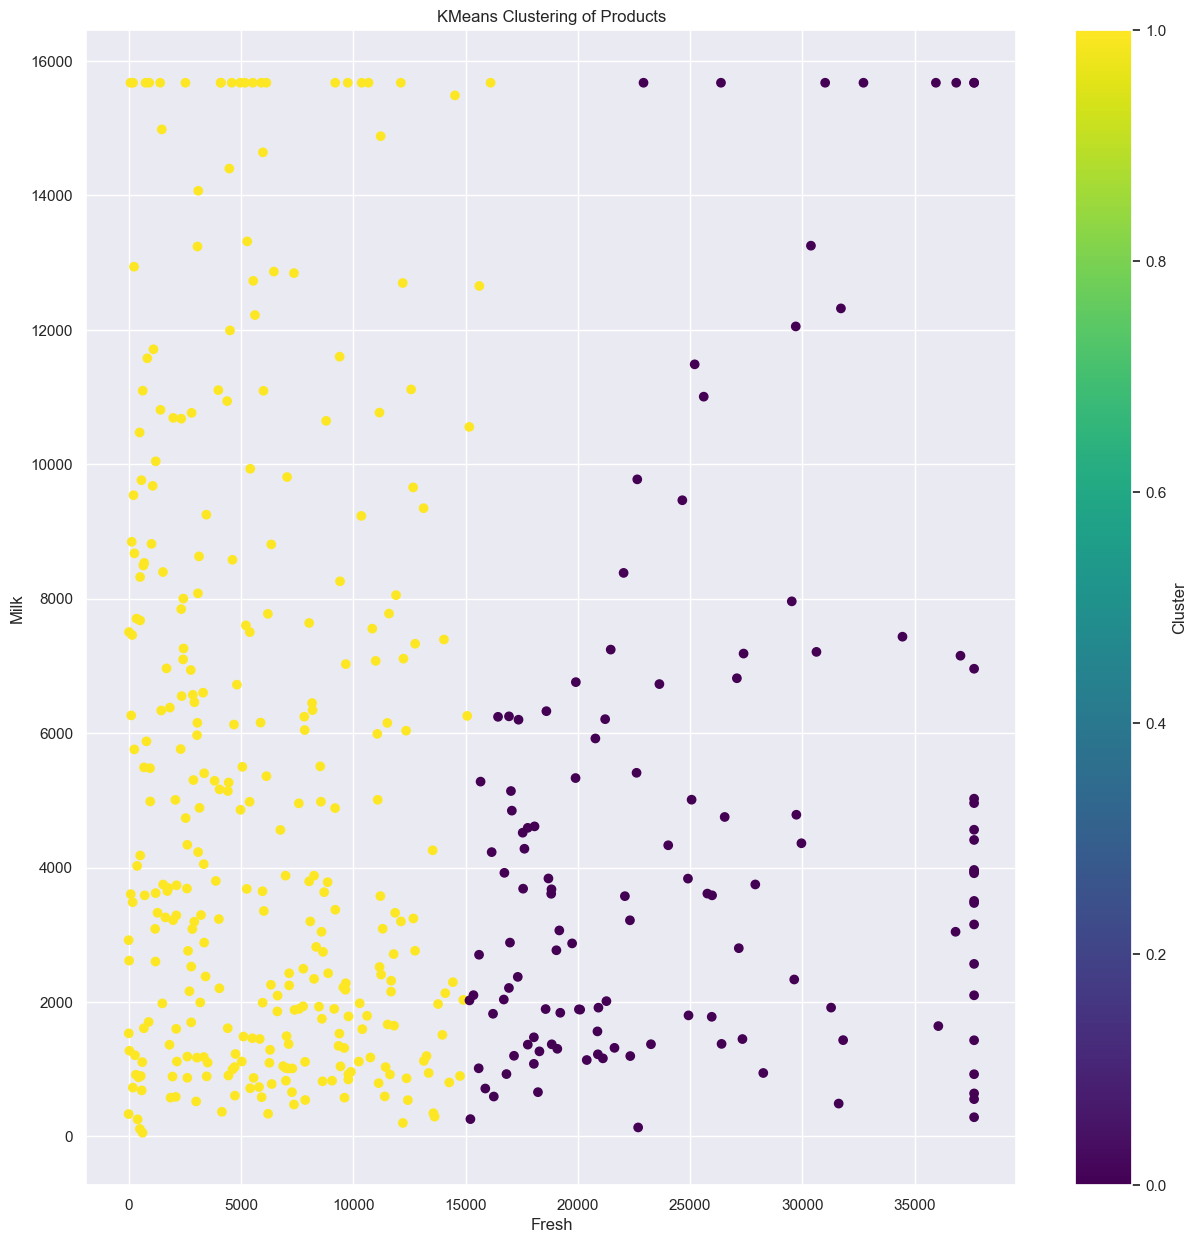

In [28]:
# Visualize the clusters
plt.scatter(data['Fresh'], data['Milk'], c=data['Cluster'], cmap='viridis')
plt.xlabel('Fresh')
plt.ylabel('Milk')
plt.title('KMeans Clustering of Products')
plt.colorbar(label='Cluster')
plt.show()

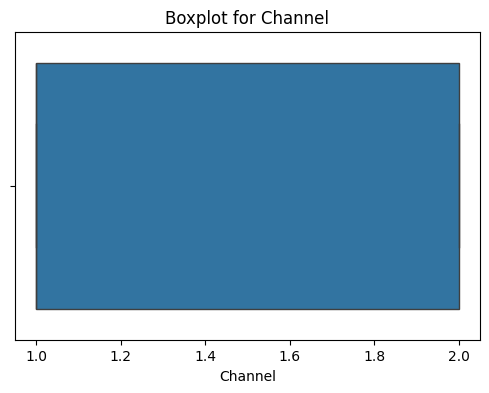

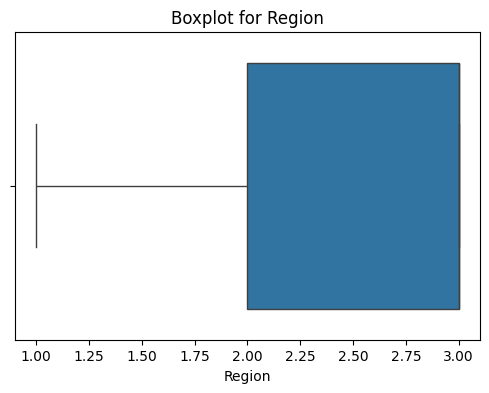

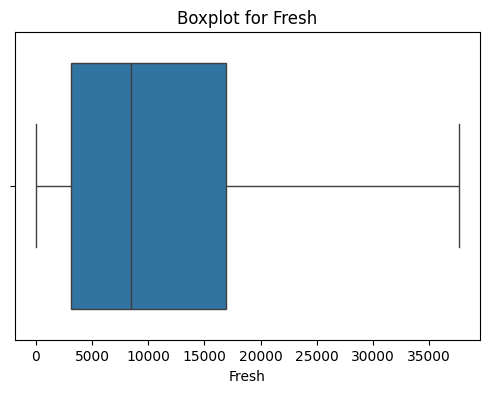

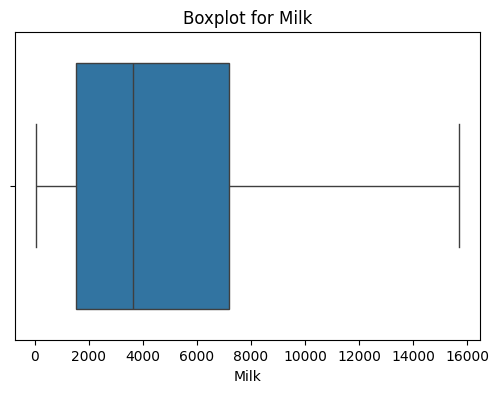

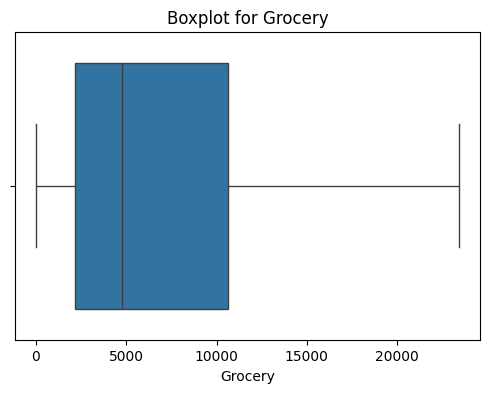

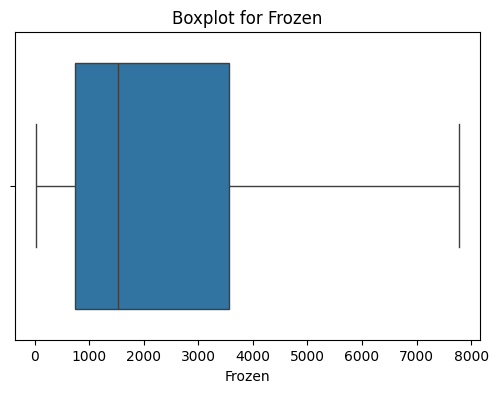

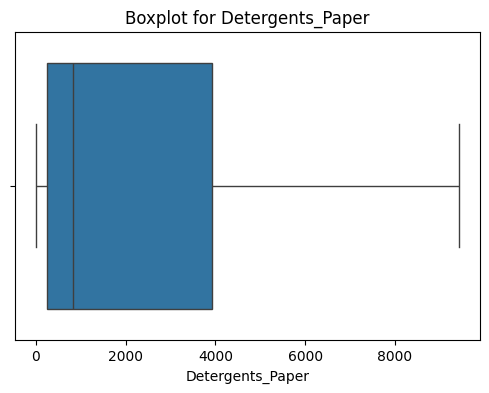

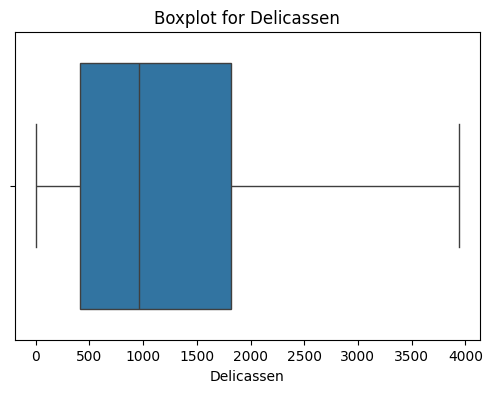

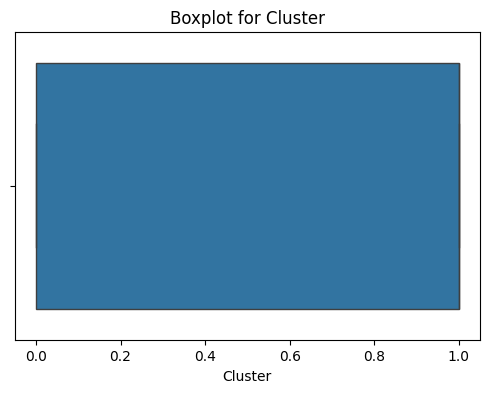

In [23]:
# checking if outliers in cluster column
data.columns = data.columns.str.strip()
numeric_columns = data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))  
    sns.boxplot(x=data[col])    
    plt.title(f"Boxplot for {col}")  
    plt.show()

### Splitting data

In [25]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

### Modeling

In [26]:
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(n_estimators=47, random_state=34),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(kernel='linear'),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42, learning_rate=0.3),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=600, learning_rate=0.05, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)  
    y_pred = clf.predict(X_test)  
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{name} Accuracy: {accuracy * 100:.2f}%')

Random Forest Classifier Accuracy: 100.00%
Logistic Regression Accuracy: 98.86%
SVM Accuracy: 97.73%
KNN Accuracy: 97.73%
Naive Bayes Accuracy: 93.18%
Decision Tree Accuracy: 100.00%
AdaBoost Accuracy: 100.00%
Gradient Boosting Accuracy: 100.00%
XGBoost Accuracy: 100.00%


In [27]:
#END